In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import pandas as pd
from scipy.spatial import distance_matrix
import numpy as np
import matplotlib.pyplot as plt
import itertools
import copy
from TrackReconstruction_functions import *

pd.options.mode.chained_assignment = None  # Disable the warning


pressure=1
diffusion="nodiff"

# hits = pd.read_hdf("../data/ATPC_0nubb/ATPC_0nubb_1bar_smear_1.h5", "MC/hits")
hits = pd.read_hdf("../data/ATPC_0nubb/ATPC_0nubb_1bar_smear_2638.h5", "MC/hits")
# hits = pd.read_hdf("../data/TrackReco/ATPC_Bi_1bar_nexus_filtered.h5", "MC/hits"); hits["z"] = hits["z"]+3000

# hits = pd.read_hdf("../data/ATPC_Tl/ATPC_Tl_1bar_smear_1.h5", "MC/hits")

# hits = pd.read_hdf("../data/Trackreco/ATPC_Tl_1bar_nodiff_reco.h5", "data")


display(hits)
event_list = hits.event_id.unique()
print(event_list)


,event_id,x,y,z,energy
0,395850,-872.465698,2421.406494,4451.626465,0.000025
1,395850,-872.745789,2420.819824,4452.049805,0.000074
2,395850,-871.317993,2423.465576,4452.322266,0.000893
3,395850,-870.322388,2425.128906,4453.188477,0.001116
4,395850,-867.811768,2428.922852,4455.103027,0.000298
...,...,...,...,...,...
62791,395909,-1659.497559,2593.557129,5073.726562,0.001141
62792,395909,-1640.950073,2594.419434,5075.068848,0.008234
62793,395909,-1655.298462,2593.802490,5076.373535,0.003323
62794,395909,-1645.186768,2594.226318,5076.387695,0.001612


[395850 395851 395852 395853 395854 395855 395856 395857 395858 395859
 395860 395861 395862 395863 395864 395865 395866 395867 395868 395869
 395870 395871 395872 395873 395874 395875 395876 395877 395878 395879
 395880 395881 395882 395883 395884 395885 395886 395887 395888 395889
 395890 395891 395892 395893 395894 395895 395896 395897 395898 395899
 395900 395901 395902 395903 395904 395905 395906 395907 395908 395909]


,event_id,x,y,z,energy
11624,395861,-882.228943,-840.145630,1850.043823,0.003770
11625,395861,-880.710144,-849.868713,1850.571045,0.009994
11626,395861,-880.479187,-844.769958,1850.905029,0.004042
11627,395861,-882.497375,-837.347778,1850.989258,0.000025
11628,395861,-882.394531,-853.005798,1851.309692,0.000719
...,...,...,...,...,...
12672,395861,-1739.025879,51.867615,2773.180176,0.003199
12673,395861,-1736.260864,54.053284,2774.692871,0.033034
12674,395861,-1738.565674,55.895714,2775.153320,0.006994
12675,395861,-1737.869141,57.080677,2778.461670,0.034199


Diffussion smear is:  0.1 mm/sqrt(cm)
Energy threshold is:  0.0 keV
diffision scale factor is:  7
Radius scale factor is:  7
Voxel scale factor is:  2.1
mean_sigma: 11
Total groups created: 1


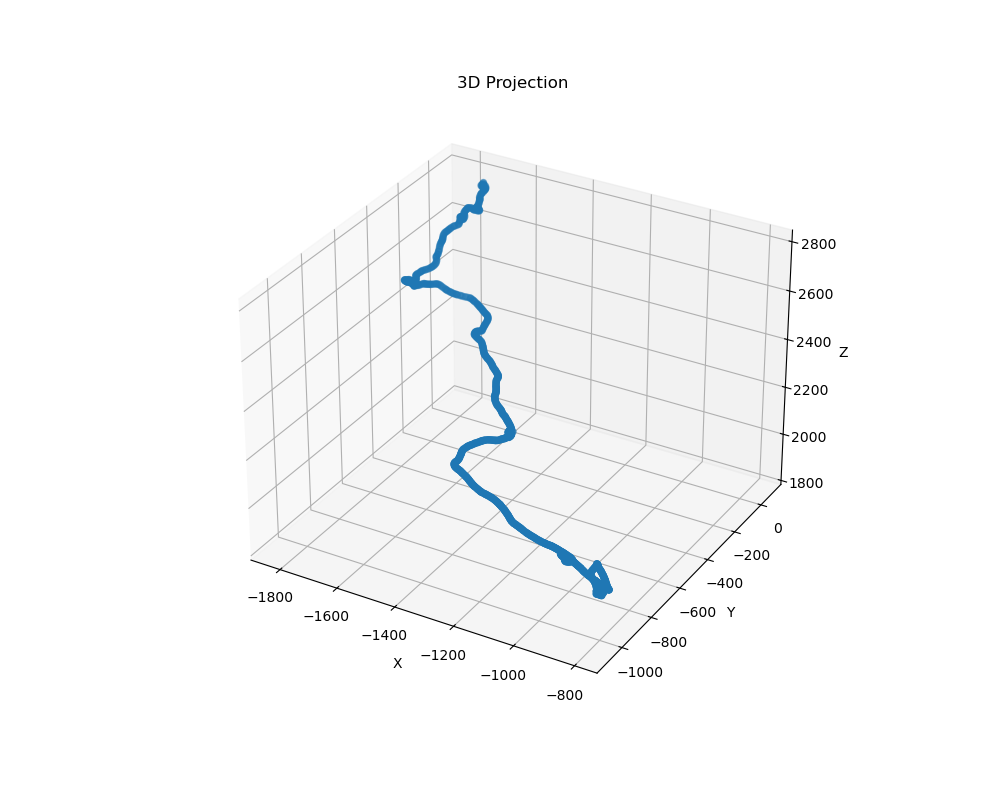

In [24]:
%matplotlib widget

data = hits[hits.event_id ==event_list[11]]
# data = hits[hits.event_id ==395909]

# There seems to be a duplicate row sometimes
data = data.drop_duplicates()

display(data)
# eid = data.event_id.item()
data = data[['event_id', 'x', 'y', 'z',"energy"]]


# Apply grouping
Diff_smear, energy_threshold, diff_scale_factor, radius_sf, voxel_sf = InitializeParams(pressure, diffusion)

print("Diffussion smear is: ",        Diff_smear,            "mm/sqrt(cm)")
print("Energy threshold is: ",        1000*energy_threshold, "keV")
print("diffision scale factor is: ",  diff_scale_factor)
print("Radius scale factor is: ",     radius_sf)
print("Voxel scale factor is: ",      voxel_sf)

mean_sigma = round(diff_scale_factor*Diff_smear*np.sqrt(0.1*data.z.mean()))
print("mean_sigma:", mean_sigma)

# Calculate the detector half-length
det_size = int(np.cbrt(6000**3/pressure)/2.0) 

# This shifts the z pos of the events so 0 is at anode
z_shift = det_size

zmin=-det_size + z_shift - mean_sigma/2 
xmin=-det_size - mean_sigma/2 
ymin=-det_size - mean_sigma/2 

reco_DE_event = data.copy()

# voxel size and parameters
voxel_size = mean_sigma  # mm
threshold = voxel_size*voxel_sf

data = GroupHits(reco_DE_event, xmin, ymin, zmin, voxel_size, threshold)

# If we have too many groups then bump up the voxel size since the track was broken too much
if (len(data.group_id.unique()) > 10):
    print("Running grouping again")
    data = GroupHits(reco_DE_event, xmin, ymin, zmin, voxel_size, voxel_size*(voxel_sf+1))


# Apply energy threshold and redistribute energy
data = CutandRedistibuteEnergy(data, energy_threshold)

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

for gid in sorted(data.group_id.unique()):
    temp_df = data[data.group_id == gid]
    ax.scatter(temp_df['x'], temp_df['y'], temp_df['z'], marker='o')


ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('3D Projection')
plt.show()



,event_id,x,y,z,energy,group_id
0,395861,-1828.706909,-274.520599,2495.955811,0.002951,0
1,395861,-1828.583618,-270.534790,2493.962158,0.002505,0
2,395861,-1828.478027,-277.555603,2497.454834,0.000174,0
3,395861,-1828.394531,-278.609833,2498.063477,0.007018,0
4,395861,-1828.274902,-267.966095,2490.944824,0.001190,0
...,...,...,...,...,...,...
1048,395861,-803.699951,-939.822876,1955.049561,0.002778,0
1049,395861,-802.574036,-937.108154,1952.493164,0.000025,0
1050,395861,-802.315002,-937.380371,1952.425903,0.000074,0
1051,395861,-802.304016,-938.489929,1953.108032,0.000149,0


Median distance to the closest row: 2.629004164171757


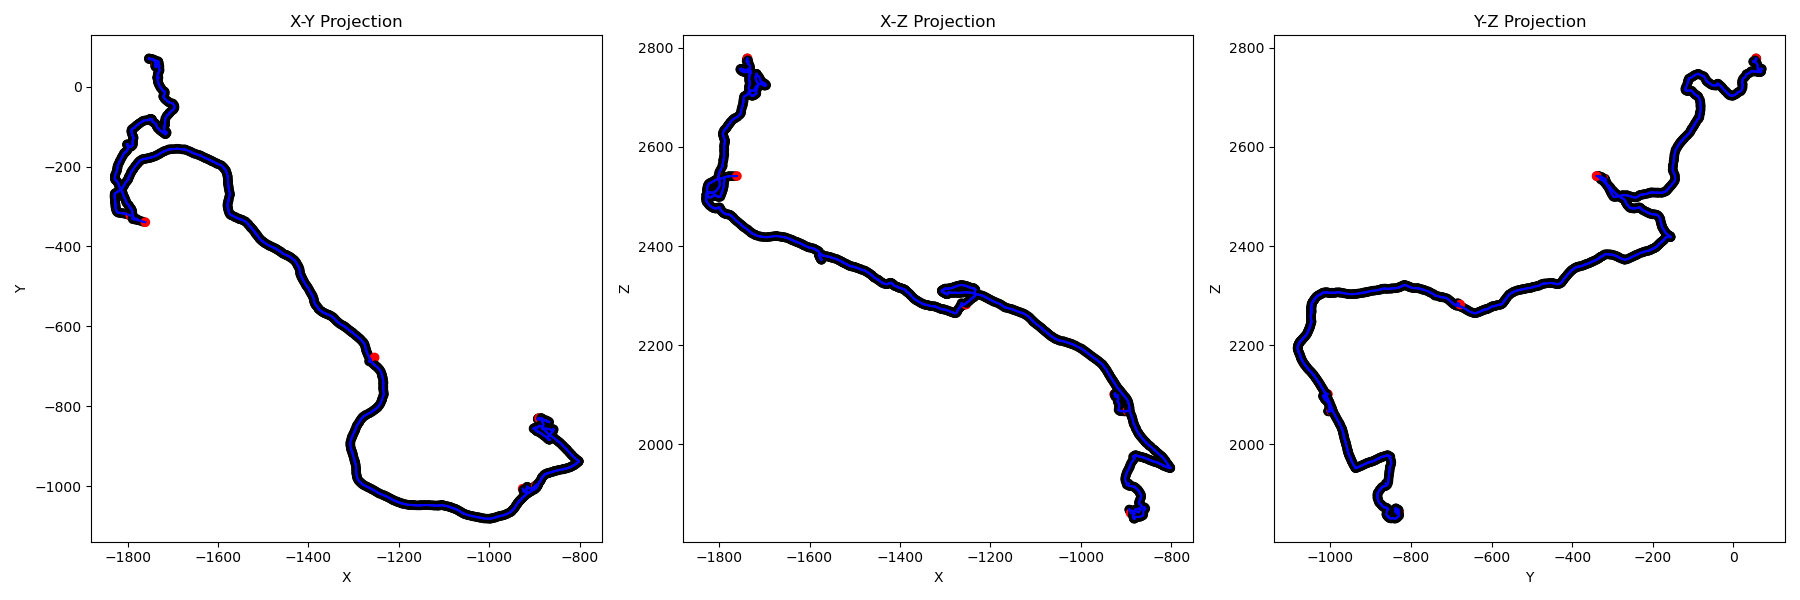

In [25]:




# shuffle the data to ensure we dont use g4 ordering
data = data.sample(frac=1).reset_index(drop=True)

# then sort it based on the x,y,z
data = data.sort_values(by=['x', "y", "z"]).reset_index(drop=True)

display(data)

df = pd.DataFrame(data)

# Calculate the distance matrix
dist_matrix = distance_matrix(data[['x', 'y', 'z']], data[['x', 'y', 'z']])

# Initialize connections counter, keeps track of number of connections to each index
connection_count = np.zeros(len(data), dtype=int)

# This is a dict, format is
# index : [connected node 1, connected node 2,...]
connected_nodes = {}
connections = []

# Tunable parameters
Meadian_dist = GetMedianNodeDistances(data) # Median distance between nodes
init_dist_thresh = Meadian_dist*2 # max distance for initial connections [mm]
incr_dist_thresh = np.linspace(1, Meadian_dist*7, 15, dtype=int) # Second stage, look for closest nodes, then slowly increase threshold [mm]
incr_dist_thresh = np.unique(incr_dist_thresh)

dist_threshold = 15 # Third distance threshold for conecting end nodes [mm]


for i in range(len(data)):
    # Find the index of the closest node (excluding itself)
    # closest_idx = np.argpartition(dist_matrix[i], 1)[1]
    closest_idx = np.argsort(dist_matrix[i])[1]
    
    # Check if the connection already exists 
    if closest_idx not in connected_nodes.get(i, []) and i not in connected_nodes.get(closest_idx, []):

        # Check the proposed node has 0 or 1 connection, the connection is within the dist threshold and is within the same group
        if (connection_count[closest_idx] <= 1 and connection_count[i] <= 1 and dist_matrix[i][closest_idx] < init_dist_thresh and CheckSameGroup(data, i, closest_idx)):
            
            cycle  = Testcycle(i, closest_idx ,connected_nodes, connections, connection_count)
            
            # Add connection between node i and closest_idx if it doesnt form a cycle
            if (not cycle):
                connected_nodes, connections, connection_count = UpdateConnections(i, closest_idx, connected_nodes, connections, connection_count)

# Get indices where the value is 1
single_nodes = np.where(connection_count == 1)[0]

# Incrementally loop over distance steps looking for connections
# starting from a small step size helps lock onto the nearest nodes
for dist in incr_dist_thresh:

    # Connect single nodes to the next closest single node
    for i in single_nodes:
        
        # Connections get updated, so this ensures we dont make a connection to a newly formed connection
        if connection_count[i] == 1:
            
            # Find the index of the closest node with one connection (excluding itself)
            sorted_indices = np.argsort(dist_matrix[i])[1:]
            
            for closest_idx in sorted_indices[:dist]:

                # Check if the index is not itelf and the connection count of the closest index is <=1, also that the proposed node is in the same group
                if closest_idx != i and connection_count[closest_idx] <= 1 and connection_count[i] <= 1 and closest_idx not in connected_nodes.get(i, []) and i not in connected_nodes.get(closest_idx, []) and CheckSameGroup(data, i, closest_idx): 
                    
                    if dist_matrix[i][closest_idx] < dist:

                        cycle  = Testcycle(i, closest_idx ,connected_nodes, connections, connection_count)
                        
                        if not cycle:
                            connected_nodes, connections, connection_count = UpdateConnections(i, closest_idx, connected_nodes, connections, connection_count)
                            break


# Function to plot connections
def plot_connections(ax, x, y, connections, connection_count, x_label, y_label):
    colors = ['r' if count == 1 or count == 0 else 'k' for count in connection_count]
    ax.scatter(x, y, c=colors, marker='o')
    for connection in connections:
        start_node = connection[0]
        end_node = connection[1]
        ax.plot([x[start_node], x[end_node]], [y[start_node], y[end_node]], 'b-')
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    ax.set_title(f'{x_label}-{y_label} Projection')

# Create subplots
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

# Plot xy projection
plot_connections(axs[0], data['x'], data['y'], connections, connection_count, 'X', 'Y')

# Plot xz projection
plot_connections(axs[1], data['x'], data['z'], connections, connection_count, 'X', 'Z')

# Plot yz projection
plot_connections(axs[2], data['y'], data['z'], connections, connection_count, 'Y', 'Z')

plt.tight_layout()
plt.show()

/var/folders/tr/r0bv1gl52_vb7v8bswkb_z0nb301gc/T/ipykernel_67117/518107878.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colormap = plt.cm.get_cmap('Dark2')


{'id': 0, 'start': 110, 'end': 895, 'nodes': [110, 104, 84, 78, 67, 65, 57, 50, 43, 37, 30, 28, 25, 22, 21, 20, 19, 18, 17, 13, 10, 7, 8, 3, 2, 0, 1, 4, 11, 14, 26, 35, 36, 40, 48, 51, 54, 60, 63, 70, 72, 77, 81, 88, 95, 98, 99, 103, 106, 109, 113, 118, 121, 135, 154, 159, 163, 166, 171, 173, 175, 178, 180, 181, 184, 187, 190, 192, 194, 196, 201, 206, 209, 216, 220, 227, 236, 237, 249, 279, 287, 290, 294, 298, 301, 307, 325, 335, 339, 344, 348, 354, 355, 356, 357, 358, 359, 360, 361, 362, 363, 364, 365, 366, 367, 368, 369, 370, 371, 372, 373, 374, 375, 376, 377, 378, 379, 380, 381, 382, 383, 384, 385, 386, 387, 388, 389, 390, 391, 392, 393, 394, 395, 398, 399, 402, 403, 404, 405, 407, 409, 413, 415, 416, 419, 421, 424, 423, 420, 418, 414, 411, 410, 401, 397, 396, 400, 406, 408, 412, 417, 422, 425, 426, 427, 428, 429, 430, 431, 432, 433, 434, 435, 437, 436, 438, 439, 440, 441, 442, 443, 444, 445, 446, 447, 448, 449, 450, 451, 452, 453, 454, 455, 456, 457, 458, 459, 460, 461, 462, 463, 4

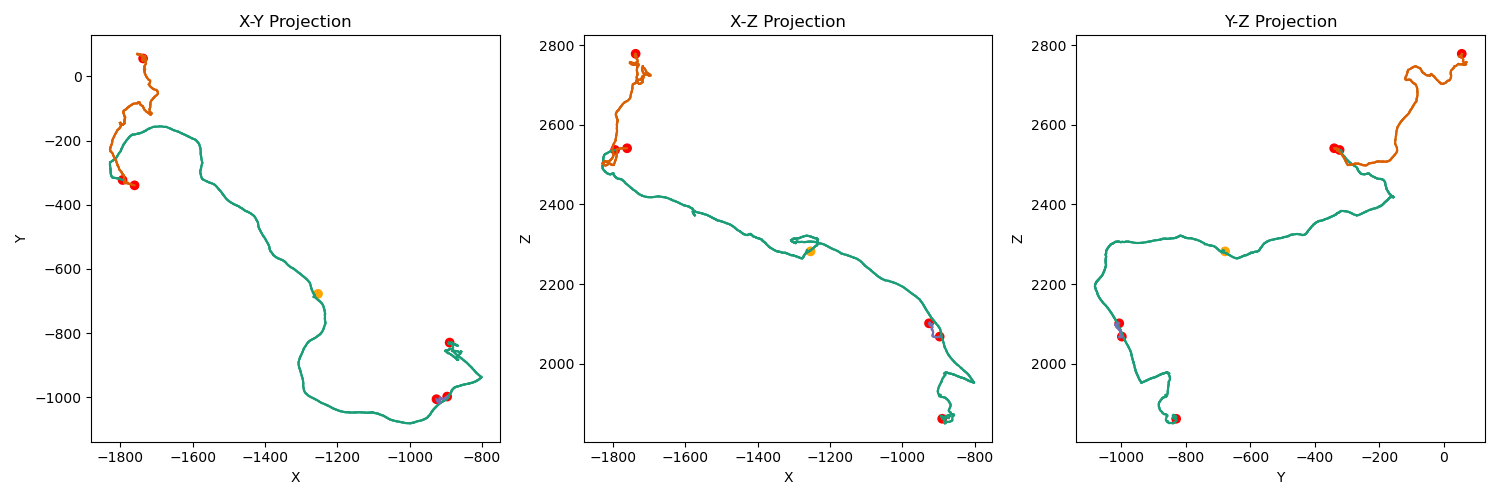

In [26]:
# Track building
colormap = plt.cm.get_cmap('Dark2')
color_cycle = itertools.cycle(colormap.colors)

# Get indices where the value is 1
single_nodes = np.where(connection_count == 1)[0]


Tracks = []

for i,node in enumerate(single_nodes):
    # Check that the track hasnt already been added
    if (check_start_end_exists(node,Tracks)):
        continue

    # Get the track path
    path = GetNodePath(connected_nodes, node, connected_nodes[node][0])

    total_length, total_energy = GetTrackLengthEnergy(path, data)
    color = next(color_cycle)

    Track = {"id":i, "start":path[0], "end":path[-1], "nodes":path, "length":total_length, "energy":total_energy,"label":"track","c":color}
    Tracks.append(Track)


for t in Tracks:
    print(t)

# Function to plot connections
def plot_tracks(ax, x, y, connection_count, x_label, y_label, Tracks_):
    # Filter data for markers with count 1 or 0
    filtered_indices = [i for i, count in enumerate(connection_count) if count == 1 or count == 0 or count == 3]
    filtered_x = [x[i] for i in filtered_indices]
    filtered_y = [y[i] for i in filtered_indices]
    
    # # Define colors for filtered data
    colors = [None] * len(filtered_indices)
    for index, i in enumerate(filtered_indices):
        if connection_count[i] == 1:
            colors[index] = "r"
        elif (connection_count[i] == 0):
            colors[index] = "Orange"
        else:
            colors[index] = "DarkGreen"

    
    # Plot filtered markers
    ax.scatter(filtered_x, filtered_y, c=colors, marker='o')

    # Plot connections
    for Track in Tracks_:
        for i, connection in enumerate(Track["nodes"]):
            if i == len(Track["nodes"]) - 1:
                break

            start_node = Track["nodes"][i]
            end_node = Track["nodes"][i + 1]

            ax.plot([x[start_node], x[end_node]],
                    [y[start_node], y[end_node]], color=Track["c"], linestyle="-")
            
        if (Track["label"] == "vertex"):
            ax.plot(x[Track["start"]], y[Track["start"]], marker = "x", color = "r" )
    
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    ax.set_title(f'{x_label}-{y_label} Projection')


# Create subplots
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Plot xy projection
plot_tracks(axs[0], data['x'], data['y'], connection_count, 'X', 'Y', Tracks)

# Plot xz projection
plot_tracks(axs[1], data['x'], data['z'], connection_count, 'X', 'Z', Tracks)

# Plot yz projection
plot_tracks(axs[2], data['y'], data['z'], connection_count, 'Y', 'Z', Tracks)

plt.tight_layout()
plt.show()

In [27]:
print(GetMedianNodeDist(Tracks, data))

dist_threshold = 4*GetMedianNodeDist(Tracks, data)
print("Dist Thresh",dist_threshold)

3.307
Dist Thresh 13.228


In [28]:
# Now look to merge tracks that are close by and identify deltas

# Add in any nodes without connections to the tracks as gammas and re-label other tracks as gammas
AddConnectionlessNodes(connection_count, Tracks, data)


In [29]:

finished = False  # Initial state

q = 0
while not finished:
    print("Loop: ", q)
    # finished, Tracks2 = ConnectTracks(Tracks2, temp_connections_dict, temp_connections, temp_connection_count)
    finished, Tracks, connected_nodes, connections, connection_count = ConnectTracks(Tracks, connected_nodes, connections, connection_count, dist_matrix, dist_threshold, data)
    q=q+1

print(finished)

print("Total Tracks:", len(Tracks))

for t in Tracks:
    print(t)



Loop:  0
Loop:  1
True
Total Tracks: 4
{'id': 3, 'start': 816, 'end': 869, 'nodes': [816, 818, 820, 819, 822, 825, 827, 828, 829, 834, 835, 833, 831, 830, 832, 837, 842, 841, 840, 838, 843, 846, 848, 852, 854, 859, 866, 869, 878], 'length': 83.476, 'energy': 0.1820320014085155, 'label': 'track', 'c': 'black'}
{'id': 4, 'start': 655, 'end': 655, 'nodes': [655, 642], 'length': 0, 'energy': 0.004414400085806847, 'label': 'gamma', 'c': 'black'}
{'id': 5, 'start': 151, 'end': 191, 'nodes': [151, 156, 161, 164, 169, 172, 176, 182, 188, 191], 'length': 33.681, 'energy': 0.05346880038268864, 'label': 'track', 'c': 'black'}
{'id': 6, 'start': 234, 'end': 895, 'nodes': [234, 233, 230, 238, 243, 242, 231, 229, 241, 253, 269, 276, 225, 223, 218, 205, 198, 197, 204, 210, 213, 221, 224, 228, 240, 244, 274, 268, 250, 270, 280, 284, 283, 281, 285, 286, 278, 267, 264, 265, 262, 257, 255, 252, 259, 261, 271, 272, 266, 258, 247, 246, 251, 256, 260, 263, 273, 275, 282, 289, 291, 293, 296, 300, 309, 315, 3

{'id': 0, 'start': 234, 'end': 895, 'length': 3441.538, 'energy': 2.2390431933599757, 'label': 'Primary', 'c': 'Teal', 'nodes': [234, 233, 230, 238, 243, 242, 231, 229, 241, 253, 269, 276, 225, 223, 218, 205, 198, 197, 204, 210, 213, 221, 224, 228, 240, 244, 274, 268, 250, 270, 280, 284, 283, 281, 285, 286, 278, 267, 264, 265, 262, 257, 255, 252, 259, 261, 271, 272, 266, 258, 247, 246, 251, 256, 260, 263, 273, 275, 282, 289, 291, 293, 296, 300, 309, 315, 313, 306, 297, 302, 308, 322, 329, 333, 336, 338, 342, 347, 349, 351, 353, 352, 350, 346, 345, 343, 341, 340, 337, 334, 332, 330, 323, 320, 319, 318, 316, 314, 311, 304, 303, 305, 310, 317, 324, 327, 331, 328, 326, 321, 312, 299, 295, 292, 288, 277, 254, 248, 245, 239, 235, 232, 226, 222, 219, 217, 215, 214, 212, 211, 208, 207, 203, 202, 200, 199, 195, 193, 189, 186, 185, 183, 179, 177, 174, 170, 168, 167, 165, 162, 160, 147, 129, 122, 119, 120, 126, 133, 137, 149, 155, 158, 157, 153, 152, 150, 140, 138, 142, 141, 136, 145, 134, 128, 1

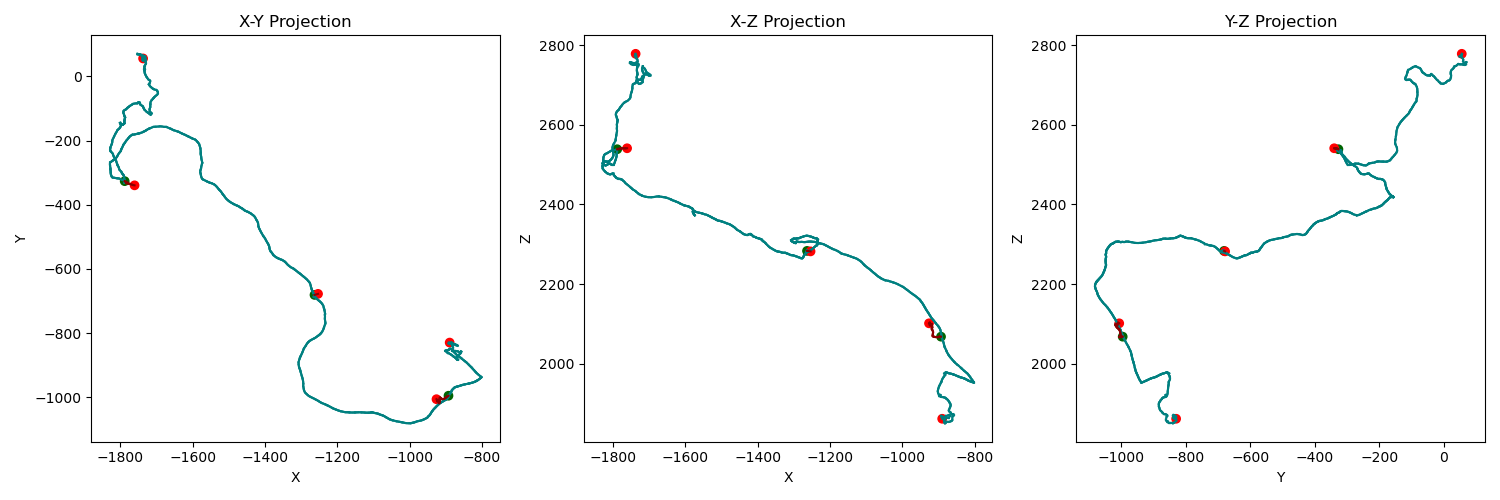

In [30]:


RebuiltTrack, pass_flag = RebuildTracks(connected_nodes, connection_count, data)

for t in RebuiltTrack:
    print(t)

print(pass_flag)


# Create subplots
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Plot xy projection
plot_tracks(axs[0], data['x'], data['y'], connection_count, 'X', 'Y', RebuiltTrack)

# Plot xz projection
plot_tracks(axs[1], data['x'], data['z'], connection_count, 'X', 'Z', RebuiltTrack)

# Plot yz projection
plot_tracks(axs[2], data['y'], data['z'], connection_count, 'Y', 'Z', RebuiltTrack)

# axs[0].scatter(data["x"].iloc[25], data["y"].iloc[25])

plt.tight_layout()
plt.show()



In [31]:
# Get the track with the most nodes, this is taken to be the primary

num_nodes = 0
primary_track_id = -1
primary_nodes = []

for t in RebuiltTrack:
    if ( len(t["nodes"]) > num_nodes):
        num_nodes = len(t["nodes"])
        primary_track_id = t["id"]
        primary_nodes = t["nodes"]

print("The primary track is: ", primary_track_id)

# This list makes sure we only have one angle per node
all_visited = []

Primary_Track = data.reindex(primary_nodes)
Primary_Track = GetAnglesDF(Primary_Track, all_visited, 1, primary_track_id)
all_visited = all_visited + primary_nodes

df_angles = pd.DataFrame()
df_angles = pd.concat([df_angles, Primary_Track], ignore_index=True)

for t in RebuiltTrack:

    trk_nodes = t["nodes"]
    if t["id"] == primary_track_id:
        continue
    else:
        
        # See if the first/last node has three connections. If it does then flip the track
        con_end = connection_count[t["nodes"][-1]]
        if (con_end == 3):
            trk_nodes = trk_nodes[::-1]
        
        trk = data.reindex(trk_nodes)

        trk = GetAnglesDF(trk, all_visited, 0, t["id"])
        all_visited = all_visited + trk_nodes
        df_angles = pd.concat([df_angles, trk], ignore_index=True)


# Primary_Track.reset_index(drop=True, inplace=True)
pd.set_option('display.max_rows', 100)
display(df_angles)

print(connected_nodes)



The primary track is:  0


,event_id,x,y,z,energy,group_id,id,primary,trkID,cumulative_distance,angle
0,395861,-1737.136353,56.172543,2778.857666,0.026387,0,234,1,0,0.000000,0.000000
1,395861,-1737.869141,57.080677,2778.461670,0.034199,0,233,1,0,1.232274,55.742910
2,395861,-1738.565674,55.895714,2775.153320,0.006994,0,230,1,0,4.814797,80.292402
3,395861,-1736.260864,54.053284,2774.692871,0.033034,0,238,1,0,7.801218,78.674059
4,395861,-1735.473877,54.149963,2771.845459,0.002480,0,243,1,0,10.756967,70.498147
...,...,...,...,...,...,...,...,...,...,...,...
1048,395861,-923.286621,-1012.642395,2096.395264,0.003968,0,822,0,3,75.380816,82.273979
1049,395861,-924.023376,-1012.557861,2097.613770,0.000322,0,819,0,3,76.807249,50.476221
1050,395861,-923.852661,-1010.115540,2102.789062,0.004514,0,820,0,3,82.532434,38.549938
1051,395861,-924.579956,-1009.292053,2100.997314,0.024205,0,818,0,3,84.634206,127.864084


{0: [2, 1], 2: [0, 3], 1: [4, 0], 4: [1, 11], 3: [2, 8], 11: [4, 14], 5: [12, 6], 12: [5, 15], 6: [9, 5], 9: [6, 16], 7: [8, 10], 8: [7, 3], 16: [9, 24], 10: [13, 7], 13: [10, 17], 14: [11, 26], 15: [12, 23], 17: [13, 18], 18: [19, 17], 19: [18, 20], 20: [19, 21], 21: [22, 20], 22: [21, 25], 23: [15, 31], 24: [27, 16], 27: [24, 29], 25: [28, 22], 28: [25, 30], 26: [35, 14], 35: [26, 36], 30: [28, 37], 29: [32, 27], 32: [29, 33], 31: [39, 23], 39: [31, 41], 33: [32, 34], 34: [33, 38], 36: [35, 40], 37: [43, 30], 43: [37, 50], 38: [34, 42], 40: [36, 48], 41: [44, 39], 44: [41, 46], 42: [45, 38], 45: [42, 47], 46: [44, 49], 47: [45, 52], 49: [46, 53], 48: [51, 40], 51: [48, 54], 50: [57, 43], 57: [50, 65], 54: [51, 60], 52: [55, 47], 55: [52, 61], 53: [56, 49], 56: [53, 58], 58: [56, 59], 59: [58, 62], 60: [63, 54], 63: [60, 70], 61: [64, 55], 64: [61, 69], 62: [66, 59], 66: [62, 68], 69: [64, 73], 65: [67, 57], 67: [65, 78], 68: [66, 71], 71: [68, 74], 73: [69, 75], 70: [72, 63], 72: [70

Text(0, 0.5, 'Scatter Angle [deg]')

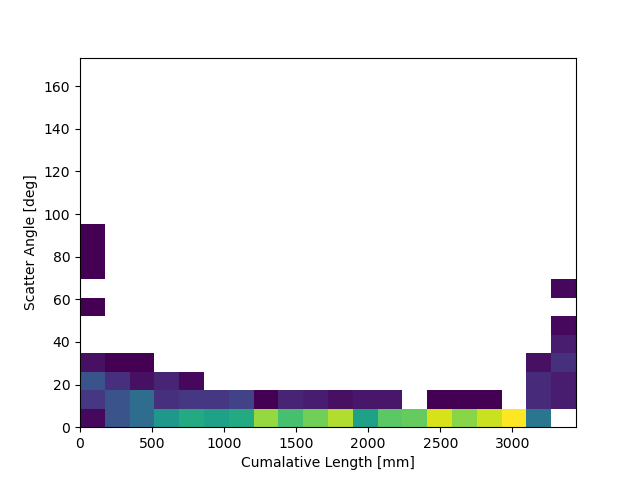

In [32]:
plt.figure()
# plt.scatter(Primary_Track.x, Primary_Track.z)

# plt.scatter(Primary_Track.index, Primary_Track.angle)

# plt.hist(Primary_Track.angle)
# plt.semilogy()
plt.hist2d(Primary_Track.cumulative_distance, Primary_Track.angle, bins = 20,cmin=3);

# plt.scatter(Primary_Track.cumulative_distance, Primary_Track.angle);

# plt.scatter(Primary_Track.cumulative_distance, Primary_Track.angle)

plt.xlabel("Cumalative Length [mm]")
plt.ylabel("Scatter Angle [deg]")

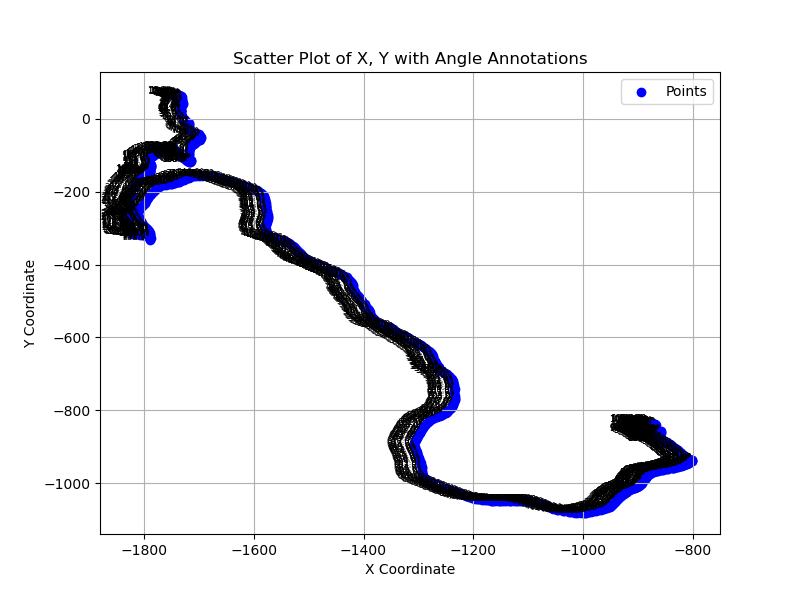

In [33]:
# Create scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(Primary_Track['x'], Primary_Track['y'], color='blue', label='Points')

# Annotate each point with the corresponding angle
for i in range(len(Primary_Track)):
    x = Primary_Track.iloc[i]['x']
    y = Primary_Track.iloc[i]['y']
    # angle = Primary_Track.loc[i, 'angle']
    angle = i
    
    # Only annotate if angle is not NaN
    if not np.isnan(angle):
        plt.text(x, y, f'{angle:.1f}°', fontsize=6, ha='right')

# Additional plot settings
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.title('Scatter Plot of X, Y with Angle Annotations')
plt.legend()
plt.grid(True)

# Show plot
plt.show()

In [34]:
# Calculate Track Tortuosity

df_angles = CalcTortuosity(df_angles)

In [35]:
display(df_angles)

,event_id,x,y,z,energy,group_id,id,primary,trkID,cumulative_distance,angle,Tortuosity
0,395861,-1737.136353,56.172543,2778.857666,0.026387,0,234,1,0,0.000000,0.000000,1.933289
1,395861,-1737.869141,57.080677,2778.461670,0.034199,0,233,1,0,1.232274,55.742910,1.939175
2,395861,-1738.565674,55.895714,2775.153320,0.006994,0,230,1,0,4.814797,80.292402,2.003110
3,395861,-1736.260864,54.053284,2774.692871,0.033034,0,238,1,0,7.801218,78.674059,2.065176
4,395861,-1735.473877,54.149963,2771.845459,0.002480,0,243,1,0,10.756967,70.498147,2.173174
...,...,...,...,...,...,...,...,...,...,...,...,...
1048,395861,-923.286621,-1012.642395,2096.395264,0.003968,0,822,0,3,75.380816,82.273979,2.033765
1049,395861,-924.023376,-1012.557861,2097.613770,0.000322,0,819,0,3,76.807249,50.476221,1.695864
1050,395861,-923.852661,-1010.115540,2102.789062,0.004514,0,820,0,3,82.532434,38.549938,1.626576
1051,395861,-924.579956,-1009.292053,2100.997314,0.024205,0,818,0,3,84.634206,127.864084,1.742493


1015


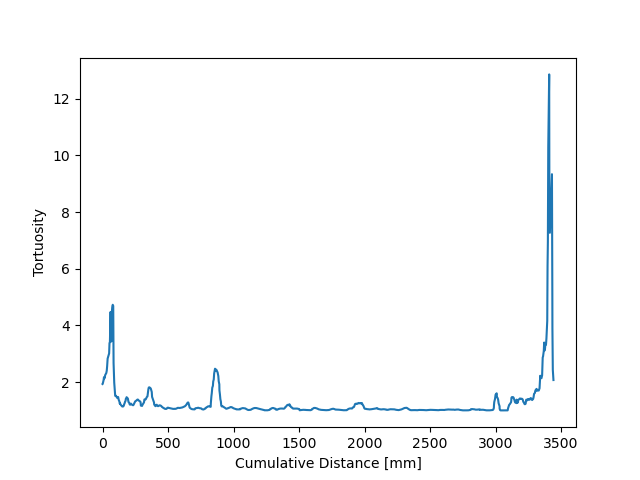

In [36]:
plt.figure()

plt.plot(df_angles[df_angles.trkID == 0].cumulative_distance, df_angles[df_angles.trkID == 0]["Tortuosity"])
plt.xlabel("Cumulative Distance [mm]")
plt.ylabel("Tortuosity")

# plt.figure()

# plt.hist(df_angles[df_angles.trkID == 0].cumulative_distance, weights = df_angles[df_angles.trkID == 0].energy, bins = 20)
# plt.xlabel("Cumulative Distance [mm]")
# plt.ylabel("Energy [MeV]")


print(len(df_angles[df_angles.trkID == 0]))

Window: 11
Window: 5
Window: 5
Window: 5


,event_id,x,y,z,energy,group_id,id,primary,trkID,cumulative_distance,angle,Tortuosity,Squiglicity
0,395861,-1737.136353,56.172543,2778.857666,0.026387,0,234,1,0,0.000000,0.000000,1.933289,1.556121
1,395861,-1737.869141,57.080677,2778.461670,0.034199,0,233,1,0,1.232274,55.742910,1.939175,1.637970
2,395861,-1738.565674,55.895714,2775.153320,0.006994,0,230,1,0,4.814797,80.292402,2.003110,1.893815
3,395861,-1736.260864,54.053284,2774.692871,0.033034,0,238,1,0,7.801218,78.674059,2.065176,2.068356
4,395861,-1735.473877,54.149963,2771.845459,0.002480,0,243,1,0,10.756967,70.498147,2.173174,2.329149
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1048,395861,-923.286621,-1012.642395,2096.395264,0.003968,0,822,0,3,75.380816,82.273979,2.033765,1.363624
1049,395861,-924.023376,-1012.557861,2097.613770,0.000322,0,819,0,3,76.807249,50.476221,1.695864,0.990623
1050,395861,-923.852661,-1010.115540,2102.789062,0.004514,0,820,0,3,82.532434,38.549938,1.626576,1.009241
1051,395861,-924.579956,-1009.292053,2100.997314,0.024205,0,818,0,3,84.634206,127.864084,1.742493,1.026763


Text(0, 0.5, 'Squiglicity')

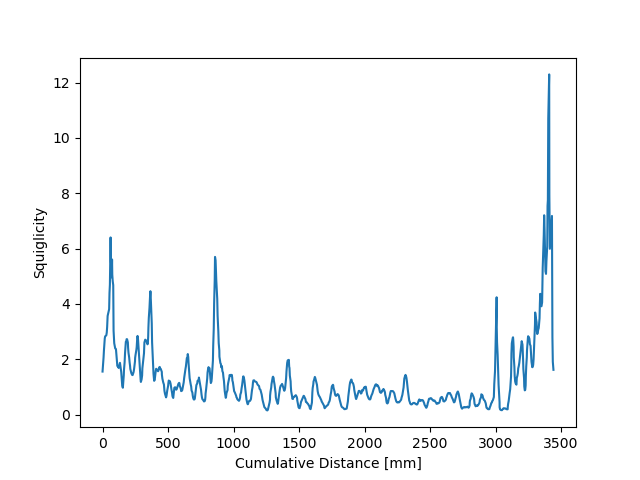

In [37]:

# Step 3: Compute perpendicular distances
def point_to_line_distance(P, A, D):
    return np.linalg.norm(np.cross(P - A, D)) / np.linalg.norm(D)

def CalcSquiglicity(df_angles):

    # df_angles['distance_diff'] = df_angles.groupby(['event_id', 'trkID'])['cumulative_distance'].diff().fillna(0)

    df_angles["Squiglicity"] = 1.0

    Squiglicity = []

    window = 10

    for trkID in df_angles.trkID.unique():

        # Get the track
        trk_df = df_angles[df_angles.trkID == trkID]

        # Try to dynamically calculate the window size by splitting into 100 pieces
        window = int(len(trk_df)/100 + 1)
        if window < 5:
            window = 5
        print("Window:",window)

        # Loop over the nodes in the track
        for index in range(len(trk_df)):

            start = max(0, index - window)  # Prevent going below index 0
            end = min(len(trk_df), index + window + 1)  # Prevent exceeding last index
            
            temp_df = trk_df.iloc[start:end]

            point1 = temp_df.iloc[0]
            point2 = temp_df.iloc[-1]
            segment_length = calculate_distance(point1, point2)

            # Avoids division by zero
            if (segment_length == 0):
                segment_length = 1


            points = temp_df[['x', 'y', 'z']].values # Get the points
            
            # Step 1: Compute centroid (a point on the best-fit line)
            A = np.mean(points, axis=0)
           
            # Step 2: Compute best-fit direction vector using SVD
            U, S, Vt = np.linalg.svd(points - A)
            D = Vt[0]  # First right-singular vector (best-fit direction)

            temp_df['distance_to_line'] = [point_to_line_distance(P, A, D) for P in points]

            # Step 4: Sum of distances
            cum_distance = temp_df['distance_to_line'].sum()

            Squiglicity.append(cum_distance/segment_length)

    df_angles["Squiglicity"] = Squiglicity

    return df_angles


df_angles = CalcSquiglicity(df_angles)
display(df_angles)


plt.figure()
plt.plot(df_angles[df_angles.trkID == 0].cumulative_distance, df_angles[df_angles.trkID == 0]["Squiglicity"])
plt.xlabel("Cumulative Distance [mm]")
plt.ylabel("Squiglicity")


In [38]:
Track_df = GetTrackdf(df_angles, RebuiltTrack, 500, 180, 200, 1) # scale these params inversely with the pressure

display(Track_df)

print(Track_df.energy.sum())



,event_id,trkID,primary,start,end,length,energy,blob1,blob2,blob1R,blob2R,Tortuosity1,Tortuosity2,TortuosityA1,TortuosityA2,Squiglicity1,Squiglicity2,SquiglicityA1,SquiglicityA2,label
0,395861,0,1,234,895,3441.538,2.239043,0.447491,0.470109,0.418946,0.458031,2.017038,3.068507,414.589093,667.052329,2.613725,4.213339,541.355840,872.502170,Primary
0,395861,1,0,151,191,33.681,0.036754,0.036754,0.036754,0.000000,0.036754,1.119694,1.119694,36.504639,36.504639,0.278014,0.278014,8.858063,8.858063,Delta0
0,395861,2,0,642,655,10.362,0.004414,0.004414,0.004414,0.000000,0.004414,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,Delta0
0,395861,3,0,878,816,87.970,0.182032,0.182032,0.182032,0.000000,0.182032,1.514701,1.514701,128.569187,128.569187,1.074894,1.074894,94.655651,94.655651,Delta0


2.4622431946190773


In [39]:

Track_df_u = UpdateTrackMeta(Track_df, df_angles, 100)

display(Track_df_u)


Swapping the blob names


,event_id,trkID,primary,start,end,length,energy,blob1,blob2,blob1R,blob2R,Tortuosity1,Tortuosity2,TortuosityA1,TortuosityA2,Squiglicity1,Squiglicity2,SquiglicityA1,SquiglicityA2,label
0,395861,0,1,895,234,3441.538,2.239043,0.470109,0.447491,0.458031,0.418946,3.068507,2.017038,667.052329,414.589093,4.213339,2.613725,872.502170,541.355840,Primary
0,395861,1,0,151,191,33.681,0.036754,0.036754,0.036754,0.000000,0.036754,1.119694,1.119694,36.504639,36.504639,0.278014,0.278014,8.858063,8.858063,Delta0
0,395861,2,0,642,655,10.362,0.004414,0.004414,0.004414,0.000000,0.004414,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,Delta0
0,395861,3,0,878,816,87.970,0.182032,0.182032,0.182032,0.000000,0.182032,1.514701,1.514701,128.569187,128.569187,1.074894,1.074894,94.655651,94.655651,Delta0
